In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

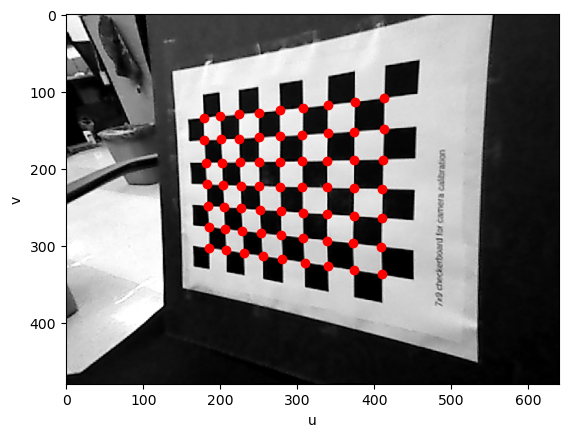

In [9]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------
# 1) Find the corner locations of the chessboard in image space.
ret, corners = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y))
# 2) Plot their location in image space over top of the image.
if ret:
    ax.plot(corners[:, 0, 0], corners[:, 0, 1], 'ro')  # 'ro' for red circles
else:
    print("Chessboard corners not found")

plt.show()
# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [17]:
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.
# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------
# 1a) Create P, an array of 2D points in the chessboard's coordinate space
x_coords = np.arange(ncorners_x) * SQUARE_SIZE
y_coords = np.arange(ncorners_y) * SQUARE_SIZE
X, Y = np.meshgrid(x_coords, y_coords)
X = X.flatten()
Y = Y.flatten()
P = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1), np.ones((X.shape[0], 1))))

# 1b) Form the M matrix
if ret:
    image_points = corners.squeeze()  # Shape (63, 2) for example
else:
    raise ValueError("Chessboard corners not detected in the image.")
M = []
for i in range(len(P)):
    X_i, Y_i, _ = P[i]
    u_i, v_i = image_points[i]  # Detected image points for the chessboard corners
    M.append([-X_i, -Y_i, -1, 0, 0, 0, u_i * X_i, u_i * Y_i, u_i])
    M.append([0, 0, 0, -X_i, -Y_i, -1, v_i * X_i, v_i * Y_i, v_i])
M = np.array(M)

# 1c) Solve for H using SVD
_, _, Vt = np.linalg.svd(M)
H = Vt[-1].reshape(3, 3)

# 2a) Compute KinvH
KinvH = np.linalg.inv(K) @ H

# 2b) Normalize KinvH
lambda_val = np.linalg.norm(KinvH[:, 0])
KinvH /= lambda_val

# 2c) Compute r0, r1, r2, and t
r0 = KinvH[:, 0]
r1 = KinvH[:, 1]
t = KinvH[:, 2]
r2 = np.cross(r0, r1)

# 2d) Form R from r0, r1, and r2
R = np.column_stack((r0, r1, r2))


print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)
# --------- YOUR CODE ENDS HERE -----------------

Rotation Matrix R:
 [[ 0.84159519  0.02457411  0.55448955]
 [ 0.04607232  1.01948989 -0.12028722]
 [-0.5381402   0.12721425  0.85686561]]
Translation Vector t:
 [-0.06041666 -0.05504642 -0.24836522]


## Problem 1.3

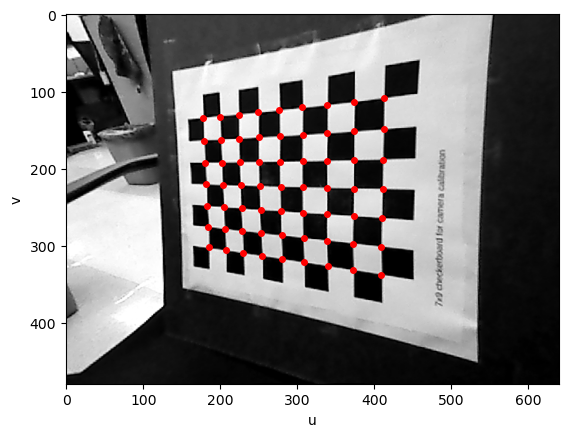

In [18]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------
    # Convert world coordinates to homogeneous coordinates (N, 4)
    world_coords_homogeneous = np.hstack([world_coords, np.ones((world_coords.shape[0], 1))])
    
    # Compute the projection: P = K * [R|t] * world_coords_homogeneous.T
    extrinsic_matrix = np.hstack((R, t.reshape(-1, 1)))  # (3, 4) extrinsic matrix
    camera_coords = extrinsic_matrix @ world_coords_homogeneous.T  # (3, N) in camera frame
    
    # Project onto image plane
    image_coords_homogeneous = K @ camera_coords  # (3, N)
    # Normalize
    image_coords = image_coords_homogeneous[:2, :] / image_coords_homogeneous[2, :]
    
    # Transpose to shape (N, 2)
    uv = image_coords.T
    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------

# Assuming R, t, K, and the previously computed checkerboard 3D world coordinates are defined
# Use X, Y from earlier with Z = 0 to form the world_coords
Z = np.zeros_like(X)  # Set Z to zero as points lie on the checkerboard plane
world_coords = np.vstack([X, Y, Z]).T  # Shape (63, 3)

# Call function to transform
projected_uv = transform_world_to_camera(K, R, t, world_coords)

# Plot the projected points on the image
ax.plot(projected_uv[:, 0], projected_uv[:, 1], 'ro', markersize=4)
plt.show()
# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

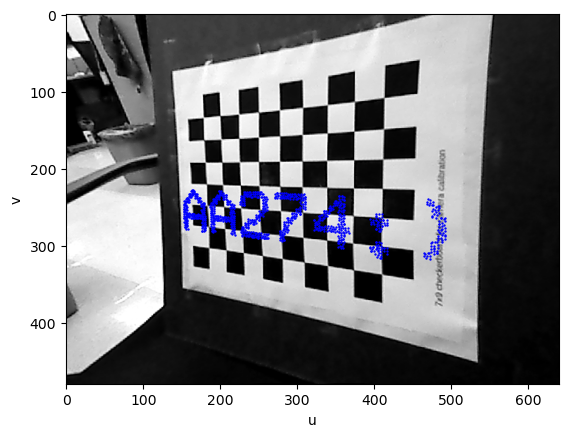

In [22]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")
plt.show()